In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
from examples.standard.plot_filter import initial_state_covariance

data = yf.download(['AMZN', 'MSFT', 'PEP', 'TSLA'],start='2015-01-01', end = '2020-01-01' )['Close']
data
log_ret_d = np.log(data/ data.shift(1)).dropna()
log_ret_w = log_ret_d.resample('W').sum()
log_ret_m = log_ret_d.resample('M').sum()
log_price = np.log(data)


/var/folders/32/x9dgly0d26z5yqyvl8t2zw3c0000gn/T/ipykernel_61836/950727621.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(['AMZN', 'MSFT', 'PEP', 'TSLA'],start='2015-01-01', end = '2020-01-01' )['Close']
[*********************100%***********************]  4 of 4 completed


[]

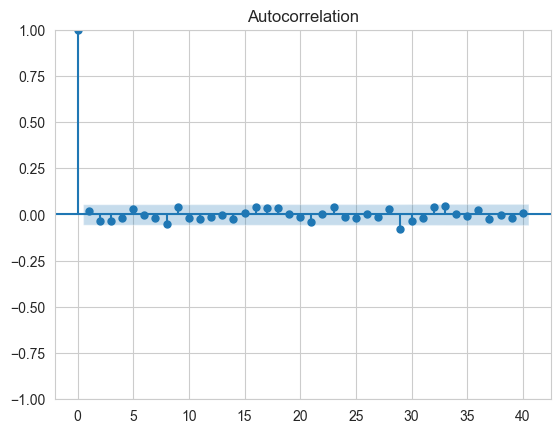

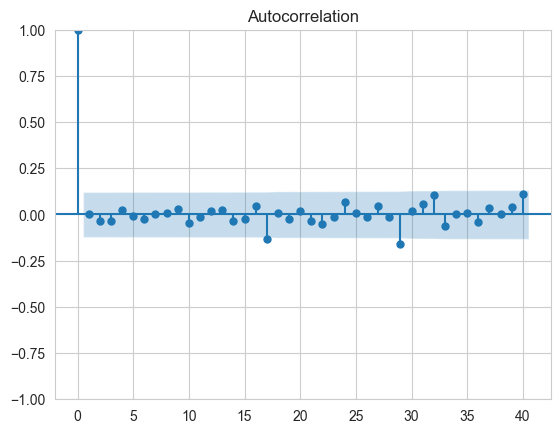

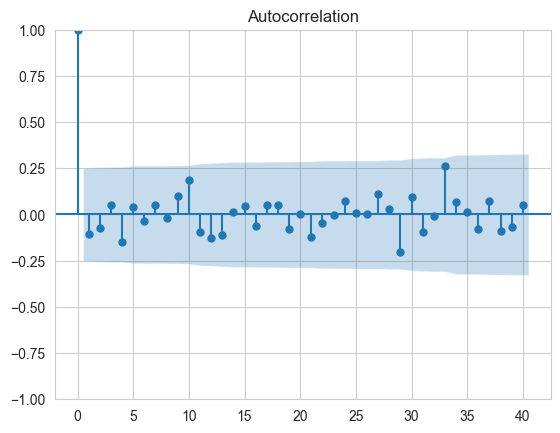

In [2]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

plot_acf(log_ret_d['AMZN'], lags = 40)
plot_acf(log_ret_w['AMZN'], lags = 40)
plot_acf(log_ret_m['AMZN'], lags = 40)
plt.plot()

In [3]:
monthly_groups = log_ret_d.groupby([log_ret_d.index.year, log_ret_d.index.month])
log_ret_m_gb = monthly_groups.sum()

log_ret_m_gb.index = pd.to_datetime([f'{y}-{m}' for y, m in log_ret_m_gb.index])

In [4]:
from statsmodels.tsa.arima.model import ARIMA
import numpy as np

q_list = [1, 2, 5, 10,]

models = {q: ARIMA(log_ret_d['AMZN'], order=(0, 0, q)).fit() for q in q_list}

for q, model in models.items():
    mse = np.mean(model.resid**2)
    print(f"MA({q}) MSE: {mse:.6f}")


/Users/macbook/Documents/MYSpace/FinPy/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/macbook/Documents/MYSpace/FinPy/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/macbook/Documents/MYSpace/FinPy/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/macbook/Documents/MYSpace/FinPy/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been

MA(1) MSE: 0.000333
MA(2) MSE: 0.000333
MA(5) MSE: 0.000332
MA(10) MSE: 0.000330


In [5]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from sklearn.metrics import mean_squared_error


alpha_list = [0.05, 0.1, 0.2, 0.5, 0.8]


models_ret_ewma = {alpha: SimpleExpSmoothing(log_ret_d['TSLA']).fit(smoothing_level=alpha, optimized=False)
                   for alpha in alpha_list}
models_price_ewma = {alpha: SimpleExpSmoothing(log_price['TSLA']).fit(smoothing_level=alpha, optimized=False)
                   for alpha in alpha_list}
print("===MSE for EWMA on Log-Returns ===")
from sklearn.metrics import mean_squared_error

print("=== MSE for EWMA on Log-Returns ===")
for alpha, model in models_ret_ewma.items():
    forecast = model.fittedvalues.shift(1)
    actual = log_ret_d['TSLA'][1:]
    mse = mean_squared_error(actual, forecast[1:])
    print(f"alpha={alpha:.2f}, MSE={mse:.8f}")

print("\n=== MSE for EWMA on Log-Prices ===")
for alpha, model in models_price_ewma.items():
    forecast = model.fittedvalues.shift(1)
    actual = log_price['TSLA'][1:]
    mse = mean_squared_error(actual, forecast[1:])
    print(f"alpha={alpha:.2f}, MSE={mse:.8f}")



===MSE for EWMA on Log-Returns ===
=== MSE for EWMA on Log-Returns ===
alpha=0.05, MSE=0.00083520
alpha=0.10, MSE=0.00084993
alpha=0.20, MSE=0.00089253
alpha=0.50, MSE=0.00105980
alpha=0.80, MSE=0.00130525

=== MSE for EWMA on Log-Prices ===
alpha=0.05, MSE=0.00764903
alpha=0.10, MSE=0.00467613
alpha=0.20, MSE=0.00296664
alpha=0.50, MSE=0.00187614
alpha=0.80, MSE=0.00163854


/Users/macbook/Documents/MYSpace/FinPy/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/macbook/Documents/MYSpace/FinPy/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/macbook/Documents/MYSpace/FinPy/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/macbook/Documents/MYSpace/FinPy/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been

In [7]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings
import itertools

warnings.filterwarnings("ignore")
param_grid = {"ar": [0,1,2, 3, 4, 5, 10],
              "ma": [0,1, 2]}
y = log_ret_d['PEP']

results = []
for p, q in itertools.product(param_grid['ar'], param_grid['ma']):
    try:
        model = ARIMA(y, order = (p, 0, q)).fit()
        forcast = model.fittedvalues.shift(1)
        actual = y[1:]
        mse = mean_squared_error(actual, forcast[1:])
        results.append(((p, q), mse))
    except Exception as e:
        results.append(((p, q), np.nan))

results = sorted(results, key= lambda x: x[1])
for (p, q), mse in results:
    print(f"ARMA({p}, {q}) - MSE: {mse:.8f}")

ARMA(1, 0) - MSE: 0.00008288
ARMA(0, 1) - MSE: 0.00008289
ARMA(1, 1) - MSE: 0.00008291
ARMA(0, 0) - MSE: 0.00008309
ARMA(0, 2) - MSE: 0.00008324
ARMA(4, 1) - MSE: 0.00008327
ARMA(4, 0) - MSE: 0.00008327
ARMA(3, 1) - MSE: 0.00008328
ARMA(2, 0) - MSE: 0.00008328
ARMA(3, 0) - MSE: 0.00008328
ARMA(2, 1) - MSE: 0.00008331
ARMA(3, 2) - MSE: 0.00008332
ARMA(4, 2) - MSE: 0.00008332
ARMA(1, 2) - MSE: 0.00008334
ARMA(2, 2) - MSE: 0.00008339
ARMA(5, 1) - MSE: 0.00008374
ARMA(5, 0) - MSE: 0.00008374
ARMA(5, 2) - MSE: 0.00008380
ARMA(10, 2) - MSE: 0.00008430
ARMA(10, 1) - MSE: 0.00008433
ARMA(10, 0) - MSE: 0.00008433


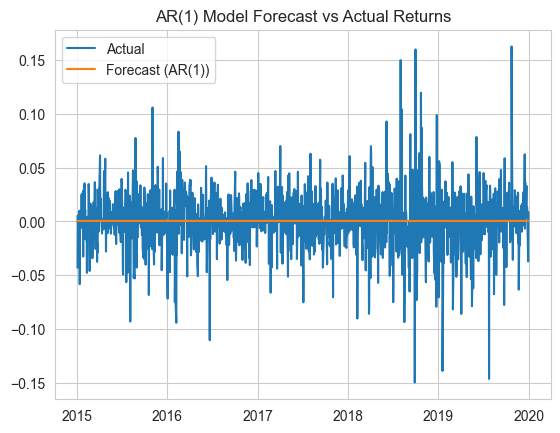

In [8]:
import matplotlib.pyplot as plt

best_model = ARIMA(log_ret_d['TSLA'].dropna(), order=(1, 0, 0)).fit()
fitted = best_model.fittedvalues
actual = log_ret_d['TSLA'].dropna()

plt.plot(actual, label="Actual")
plt.plot(fitted.shift(1), label="Forecast (AR(1))")
plt.legend()
plt.title("AR(1) Model Forecast vs Actual Returns")
plt.show()


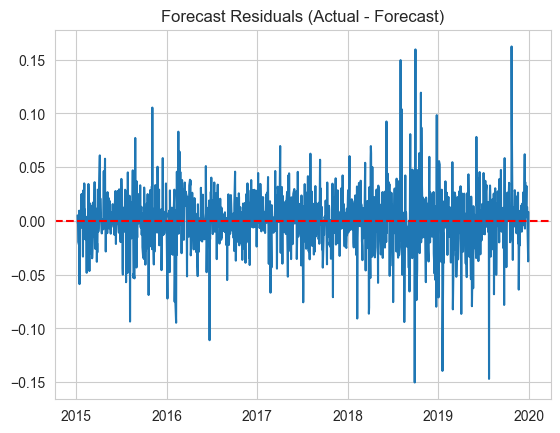

In [9]:
residuals = actual - fitted.shift(1)
plt.plot(residuals)
plt.title("Forecast Residuals (Actual - Forecast)")
plt.axhline(0, color='red', linestyle='--')
plt.show()


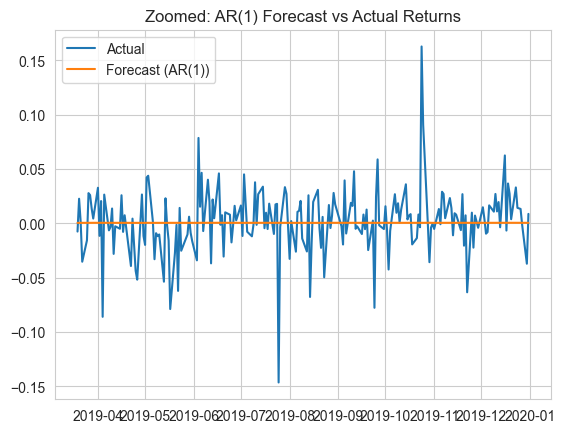

In [10]:
plt.plot(actual[-200:], label="Actual")
plt.plot(fitted.shift(1)[-200:], label="Forecast (AR(1))")
plt.legend()
plt.title("Zoomed: AR(1) Forecast vs Actual Returns")
plt.show()


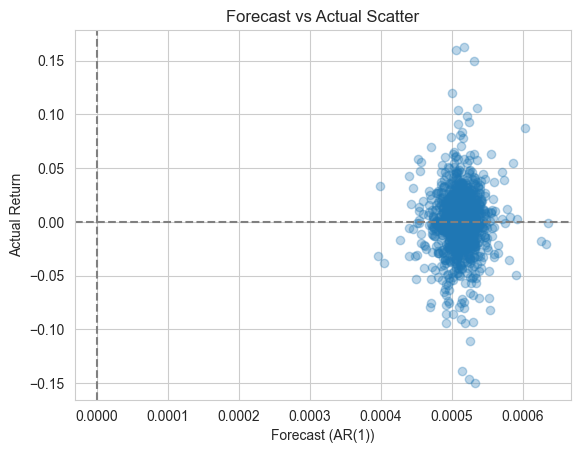

In [11]:
plt.scatter(fitted.shift(1)[1:], actual[1:], alpha=0.3)
plt.xlabel("Forecast (AR(1))")
plt.ylabel("Actual Return")
plt.title("Forecast vs Actual Scatter")
plt.axhline(0, color='grey', linestyle='--')
plt.axvline(0, color='grey', linestyle='--')
plt.show()


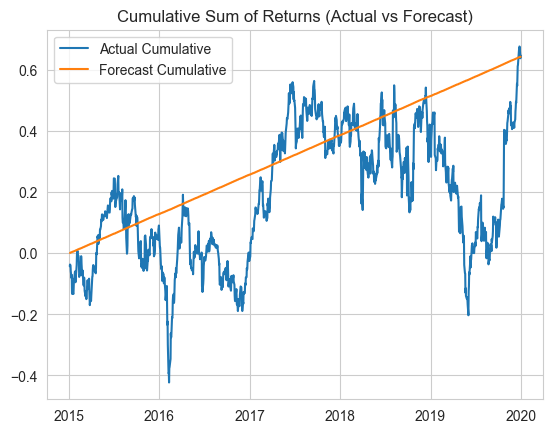

In [12]:
plt.plot(actual.cumsum(), label="Actual Cumulative")
plt.plot(fitted.shift(1).cumsum(), label="Forecast Cumulative")
plt.legend()
plt.title("Cumulative Sum of Returns (Actual vs Forecast)")
plt.show()


[*********************100%***********************]  1 of 1 completed


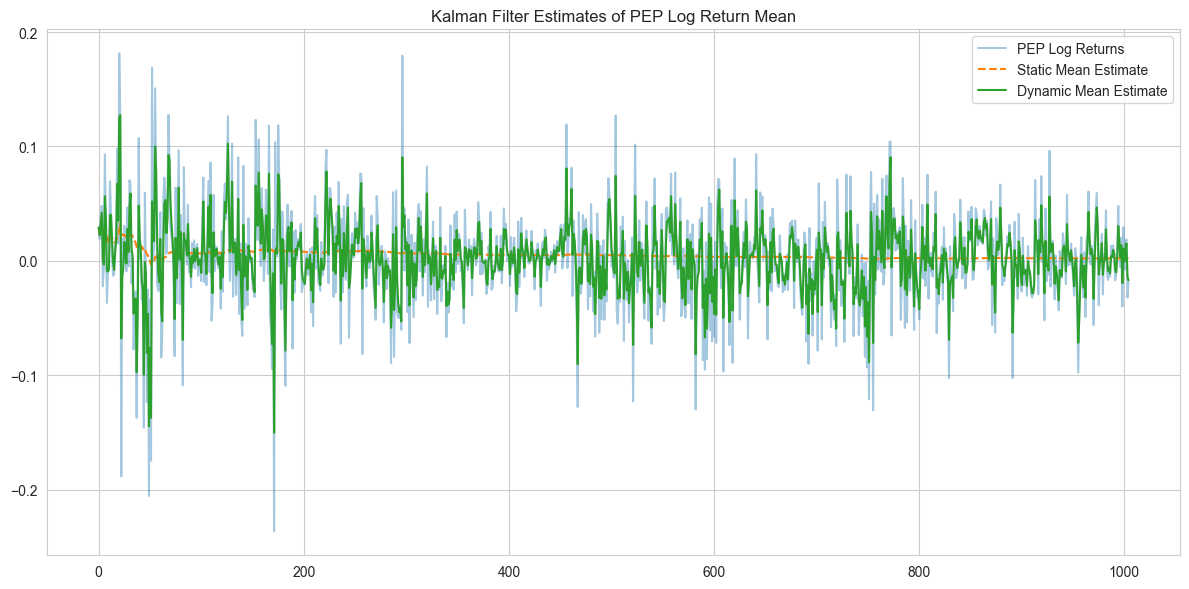

,MSE
Static Mean,0.001859
Dynamic Mean,0.002646


In [28]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
from sklearn.metrics import mean_squared_error

# Download daily log returns for PepsiCo (PEP)
data = yf.download('TSLA', start='2020-01-01', end='2024-01-01')
data['log_return'] = np.log(data['Close'] / data['Close'].shift(1))
data = data.dropna()

# Extract log returns
returns = data['log_return'].values

# Create different Kalman Filters for mean modeling
results = {}

# Model 1: Constant mean (no state evolution)
kf_static = KalmanFilter(
    transition_matrices=[1],
    observation_matrices=[1],
    transition_covariance=0.0,  # no evolution
    observation_covariance=0.0001,
    initial_state_mean=0,
    initial_state_covariance=1
)
state_mean_static, _ = kf_static.filter(returns)
forecast_static = state_mean_static[:-1].flatten()
mse_static = mean_squared_error(returns[1:], forecast_static)
results['Static Mean'] = mse_static

# Model 2: Random walk (dynamic mean)
kf_dynamic = KalmanFilter(
    transition_matrices=[1],
    observation_matrices=[1],
    transition_covariance=0.0001,  # allow evolution
    observation_covariance=0.0001,
    initial_state_mean=0,
    initial_state_covariance=1
)
state_mean_dynamic, _ = kf_dynamic.filter(returns)
forecast_dynamic = state_mean_dynamic[:-1].flatten()
mse_dynamic = mean_squared_error(returns[1:], forecast_dynamic)
results['Dynamic Mean'] = mse_dynamic

# Plot the filters
plt.figure(figsize=(12, 6))
plt.plot(returns, label='PEP Log Returns', alpha=0.4)
plt.plot(state_mean_static, label='Static Mean Estimate', linestyle='--')
plt.plot(state_mean_dynamic, label='Dynamic Mean Estimate', linestyle='-')
plt.title("Kalman Filter Estimates of PEP Log Return Mean")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Display MSEs
mse_df = pd.DataFrame.from_dict(results, orient='index', columns=['MSE'])
mse_df


In [40]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm


# Extract log returns
returns = data['log_return'].values

# --- ARMA(1,1) model ---
arma_model = sm.tsa.ARIMA(returns, order=(1, 0, 1)).fit()
arma_forecast = arma_model.predict(start=1, end=len(returns)-1)
arma_mse = mean_squared_error(returns[1:], arma_forecast)

# --- State-space (Kalman) model ---
ssm_model = sm.tsa.SARIMAX(returns, order=(1, 0, 1))
ssm_results = ssm_model.fit()
ssm_forecast = ssm_results.predict(start=1, end=len(returns)-1)
ssm_mse = mean_squared_error(returns[1:], ssm_forecast)

varma_model = sm.tsa.VARMA(returns, order = (1, 0, 0)).fit()
varma_forcast = varma_model.predict(start = 1, end = len(returns) - 1)
varma_mse = mean_squared_error(returns[1:], varma_forcast)

# --- Results ---
print(f"ARMA(1,1) MSE: {arma_mse:.6f}")
print(f"State-Space (Kalman) MSE: {ssm_mse:.6f}")

# --- Plot forecasts ---
plt.figure(figsize=(12, 6))
plt.plot(returns, label='Actual Returns', alpha=0.5)
plt.plot(range(1, len(returns)), arma_forecast, label='ARMA(1,1) Forecast', linestyle='--')
plt.plot(range(1, len(returns)), ssm_forecast, label='Kalman Forecast', linestyle='-')
plt.title("ARMA vs Kalman Forecast on TSLA Log Returns")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


[*********************100%***********************]  3 of 3 completed


ValueError: Cannot set a DataFrame with multiple columns to the single column log_return

In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.varmax import VARMAX
from sklearn.metrics import mean_squared_error

# Config
tickers = ['TSLA', 'AAPL', 'MSFT']
start_date = '2020-01-01'
end_date = '2024-01-01'
window = 500
order_arima = (1, 0, 1)
order_varmax = (1, 0)

# Download data and compute log returns
data = yf.download(tickers, start=start_date, end=end_date)['Close']
log_returns = np.log(data / data.shift(1)).dropna()


/var/folders/32/x9dgly0d26z5yqyvl8t2zw3c0000gn/T/ipykernel_63347/4177321902.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)['Close']
[*********************100%***********************]  3 of 3 completed


In [3]:
def rolling_arima(series: pd.Series, order=(1, 0, 1), window=250):
    preds, trues = [], []
    for i in range(window, len(series)-1):
        train = series.iloc[i-window:i]
        model = ARIMA(train, order=order).fit()
        forecast = model.forecast(steps=1)
        preds.append(forecast.iloc[0])        # ✅ use .iloc[0] not [0]
        trues.append(series.iloc[i])
    return np.array(preds), np.array(trues)

def rolling_varmax(df: pd.DataFrame, target_col: str, order=(1, 0), window=500):
    preds, trues = [], []
    for i in range(window, len(df)-1):
        train = df.iloc[i-window:i]
        true_val = df[target_col].iloc[i]
        try:
            model = VARMAX(train, order=order).fit(disp=False)
            forecast = model.forecast(steps=1)
            preds.append(forecast[target_col].iloc[0])  # ✅ safe access
            trues.append(true_val)
        except:
            continue
    return np.array(preds), np.array(trues)


In [ ]:
arma_mse_results = {}
varma_mse_results = {}

for ticker in tickers:
    arima_preds, arima_true = rolling_arima(log_returns[ticker], order=order_arima, window=window)
    arma_mse_results[ticker] = mean_squared_error(arima_true, arima_preds)

    varma_preds, varma_true = rolling_varmax(log_returns, target_col=ticker, order=order_varmax, window=window)
    varma_mse_results[ticker] = mean_squared_error(varma_true, varma_preds)

# Print MSE Comparison
print("\n📊 Rolling MSE Comparison:")
for ticker in tickers:
    print(f"{ticker}:")
    print(f"  ARIMA  MSE  = {arma_mse_results[ticker]:.6f}")
    print(f"  VARMAX MSE = {varma_mse_results[ticker]:.6f}")

# Plot example forecast
plt.figure(figsize=(12, 6))
plt.plot(arima_true, label='Actual TSLA', alpha=0.5)
plt.plot(arima_preds, label='ARIMA Forecast', linestyle='--')
plt.plot(varma_preds, label='VARMAX Forecast', linestyle='-')
plt.title("Forecast: TSLA — ARIMA vs VARMAX (Rolling)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
print("Rolling MSE Comprison:\n")
for ticker in tickers:
    print(f"{ticker}")
    print(f" ARIMA MSE = {arma_mse_results[ticker]:.6f}")
    print(f"VARMAX MSE = {varma_mse_results[ticker]:.6f}")

In [ ]:

from statsmodels.tsa.arima.model import ARIMA
import numpy as np

def select_best_arima(series, p_range=3, d_range=2, q_range=3, criterion='aic'):
    best_score = np.inf
    best_order = None
    for p in range(p_range):
        for d in range(d_range):
            for q in range(q_range):
                try:
                    model = ARIMA(series, order=(p, d, q)).fit()
                    score = model.aic if criterion == 'aic' else model.bic  # ✅ fixed syntax
                    if score < best_score:
                        best_score = score
                        best_order = (p, d, q)  # ✅ correct order of parameters
                except:
                    continue
    return best_order, best_score



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Generate synthetic ARIMA-like data
np.random.seed(42)
n = 200
noise = np.random.normal(scale=1, size=n)
data = pd.Series(np.cumsum(noise))  # simulates an ARIMA(0,1,0)

# Plot it
plt.plot(data)
plt.title("Synthetic ARIMA-like Series")
plt.grid(True)
plt.show()

# Run model selection
best_order, best_score = select_best_arima(data, p_range=3, d_range=2, q_range=3, criterion='aic')
print(f"Best ARIMA order: {best_order}, AIC: {best_score:.2f}")
